# Steven Ly - RL Exercise

For this exercise I have chosen the frozen lake environment from Gymnasium. This is a 8x8 grid where the agent needs to reach a goal in the grid without falling into a hole. The environment is stochastic because slippery is enabled. This means the agent has a 0.33 chance of stepping in the direction it intends to go. The other 0.67 chance is split between the left or right direction relative to the intended direction.

Alpha = learning rate. The higher the value the more the agent will learn from each step
Gamma = discount factor. The higher the value the more the agent will consider future rewards
Epsilon = exploration rate. The higher the value the more the agent will explore
Epsilon Decay Rate = rate at which epsilon decays. The higher the value the faster the agent will stop exploring

As seen in the code below, the agent receives a punishment of -1 each time it takes a step, a punishment of -5 each time it falls into a hole, and a reward of 50 each time it reaches the goal. The agent is trained for 12000 episodes.

In [1]:
import pickle
import random
import gymnasium as gym
import numpy as np
from matplotlib import pyplot as plt

def initialize_q_table(is_training, state_space_count, action_space_count):
    """Method for initializing the Q-table
    
    :param is_training: whether to train the agent or to load the pre-trained model "frozen_lake8x8.pkl"
    :param state_space_count: amount of states in the environment
    :param action_space_count: amount of actions in the environment
    """
    if is_training:
        return np.zeros((state_space_count, action_space_count))
    f = open('frozen_lake8x8.pkl', 'rb')
    q_table = pickle.load(f)
    f.close()
    return q_table

def run(episodes, alpha, gamma, epsilon, epsilon_decay_rate, render=True, is_training=True):
    """Method for running the Frozen Lake environment
     
    :param episodes: amount of episodes to run
    :param alpha: learning rate
    :param gamma: discount factor
    :param epsilon: exploration rate
    :param epsilon_decay_rate: rate at which epsilon decays
    :param render: visual rendering of the environment
    :param is_training: whether to train the agent or to load the pre-trained model "frozen_lake8x8.pkl"
    
    output: plot of the average rewards per 500 episodes and the trained model "frozen_lake8x8.pkl"
    """
    env = gym.make("FrozenLake-v1", map_name="8x8", render_mode='human' if render else None)

    action_space_count = env.action_space.n
    state_space_count = env.observation_space.n

    reward_win = 50  # Reward for reaching the goal
    reward_step = -1   # Penalty for taking a step
    reward_fall = -5 # Penalty for falling into a hole
    
    q_table = initialize_q_table(is_training, state_space_count, action_space_count)
    
    rewards_per_episode = np.zeros(episodes)

    for episode in range(episodes):
        state = env.reset()[0]
        done = False

        while not done:
            if random.uniform(0, 1) < epsilon: # Chance of exploring based on epsilon
                action = np.random.randint(0, action_space_count)
            else: # Exploiting based on Q-table
                action = np.argmax(q_table[state, :])

            next_state, reward, terminated, truncated, info = env.step(action)

            if terminated and reward == 1:
                reward += reward_win  
                rewards_per_episode[episode] = reward
            elif terminated and reward == 0:
                reward += reward_fall 
            else:
                reward += reward_step 

            epsilon = max(epsilon - epsilon_decay_rate, 0)
                
            q_table[state][action] = (1 - alpha) * q_table[state][action] + alpha * (
                    reward + gamma * np.max(q_table[next_state, :])) # Updating Q-table

            state = next_state
            if terminated or truncated:
                env.reset()
                done = True

    total_rewards_per_x_amount = []
    for i in range(0, episodes, 500):
        average_reward = np.sum(rewards_per_episode[i:i+500])
        total_rewards_per_x_amount.append(average_reward)
    plt.plot(total_rewards_per_x_amount)
    plt.xlabel('500 Episodes')
    plt.ylabel('Total rewards per 500 episodes')
    plt.title(f"{episodes} Episodes - Alpha: {alpha}, Gamma: {gamma}, Epsilon: {epsilon}, Epsilon Decay Rate: {epsilon_decay_rate}")
    plt.show()

    if is_training:
        f = open("frozen_lake8x8.pkl", "wb")
        pickle.dump(q_table, f)
        f.close()

# Training the agent

In the following codeblocks, I will train the agent with different hyperparameters and observe the results.

## Discount Factor (Gamma)
The first codeblock I will analyze the effect of the discount factor (gamma). I would assume that a high discount factor is optimal for this environment since all the agent needs to accomplish is to reach the goal.

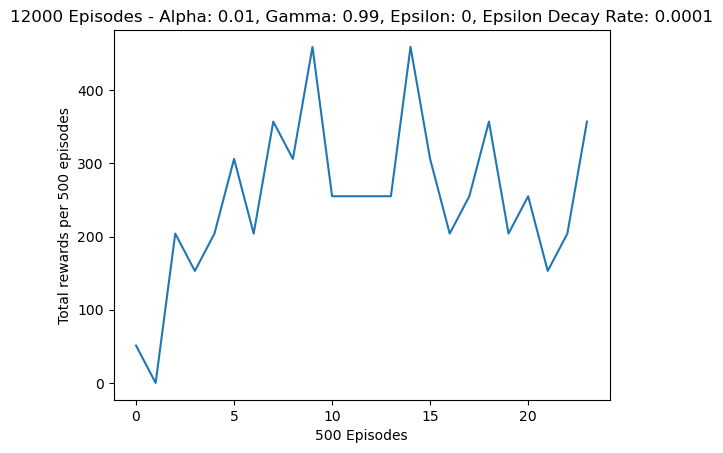

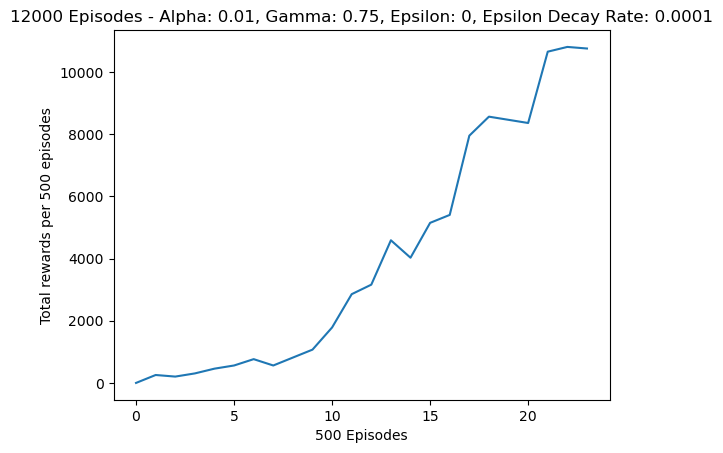

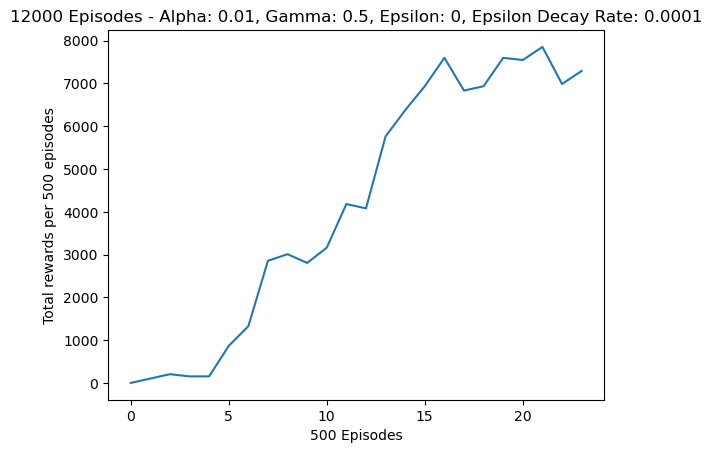

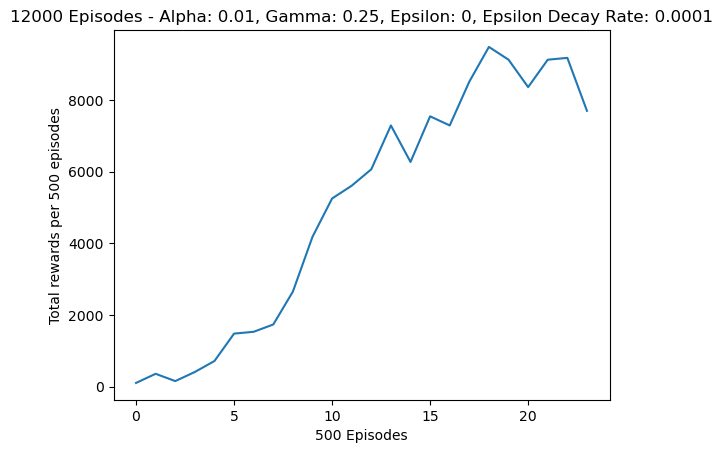

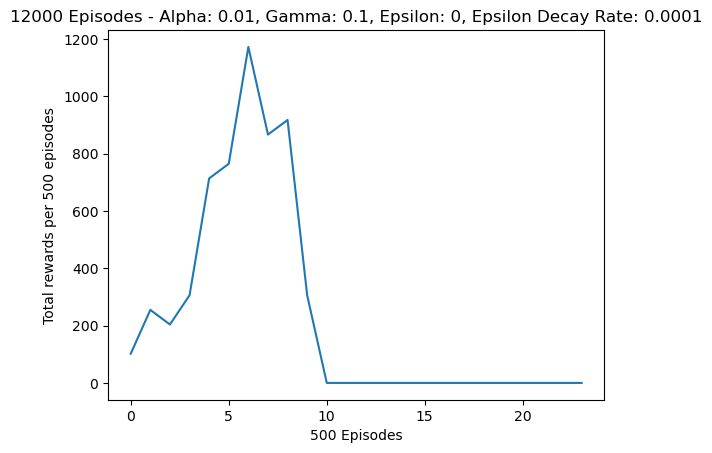

In [2]:
run(12000, alpha=0.01, gamma=0.99, epsilon=1.0, epsilon_decay_rate=0.0001, render=False, is_training=True)
run(12000, alpha=0.01, gamma=0.75, epsilon=1.0, epsilon_decay_rate=0.0001, render=False, is_training=True)
run(12000, alpha=0.01, gamma=0.5, epsilon=1.0, epsilon_decay_rate=0.0001, render=False, is_training=True)
run(12000, alpha=0.01, gamma=0.25, epsilon=1.0, epsilon_decay_rate=0.0001, render=False, is_training=True)
run(12000, alpha=0.01, gamma=0.1, epsilon=1.0, epsilon_decay_rate=0.0001, render=False, is_training=True)

As seen in the plots above, a discount factor of 0.99 generates bad results. The agent generates better results when the discount factor is lowered. A discount factor of 0.75 seems to be the best for this environment since it generates the highest rewards per 500 episodes, especially when looking at x=20 (10000 episodes). The discount factors of 0.5 and 0.25 also generates good results, but the discount factor of 0.1 generates the worst results. To my surprise, the discount factor of 0.99 is not optimal and lower values are commonly better. I think the agent is more encouraged to explore with a lower discount factor.

## Learning Rate (Alpha)
The next codeblock I will analyze the effect of the learning rate (alpha), continuing with the discount factor of 0.75.

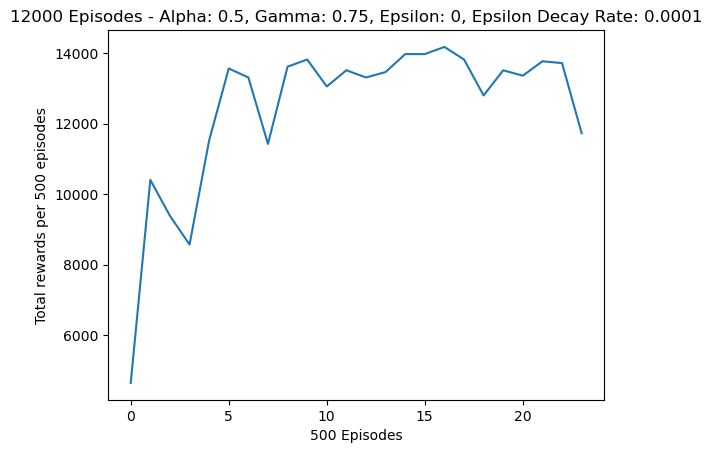

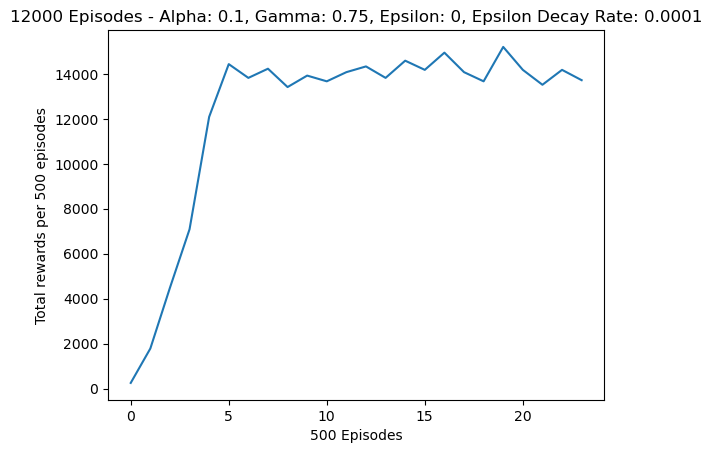

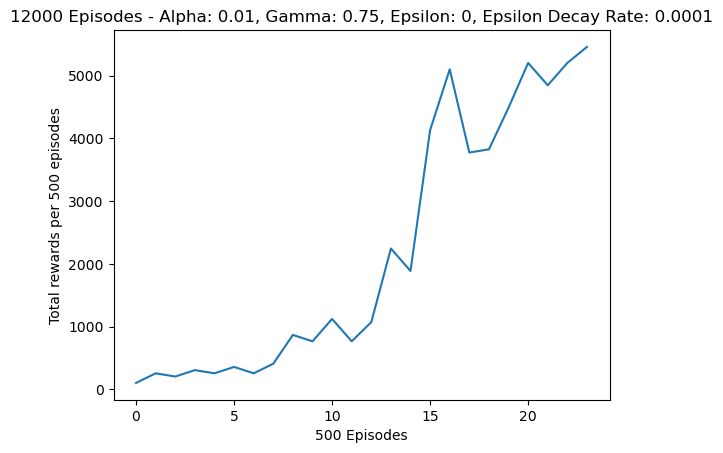

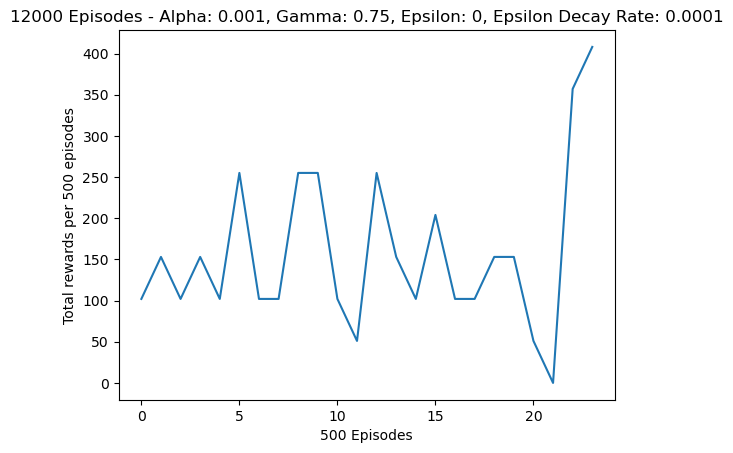

In [7]:
run(12000, alpha=0.5, gamma=0.75, epsilon=1.0, epsilon_decay_rate=0.0001, render=False, is_training=True)
run(12000, alpha=0.1, gamma=0.75, epsilon=1.0, epsilon_decay_rate=0.0001, render=False, is_training=True)
run(12000, alpha=0.01, gamma=0.75, epsilon=1.0, epsilon_decay_rate=0.0001, render=False, is_training=True)
run(12000, alpha=0.001, gamma=0.75, epsilon=1.0, epsilon_decay_rate=0.0001, render=False, is_training=True)

As seen in the plots above, a learning rate of 0.1 seems to be the best since it consistently hovers around a high total reward of 14000 per 500 episodes. A learning rate of 0.5 is slightly too high since it fluctuates very much around 14000 and 13000. The learning rates below 0.1, so 0.01 and 0.001, are too low since the agent is not learning fast enough.

## Epsilon Decay Rate
The next codeblock I will analyze the effect of the exploration rate decay (epsilon_decay_rate), continuing with the discount factor of 0.75 and the learning rate of 0.1.

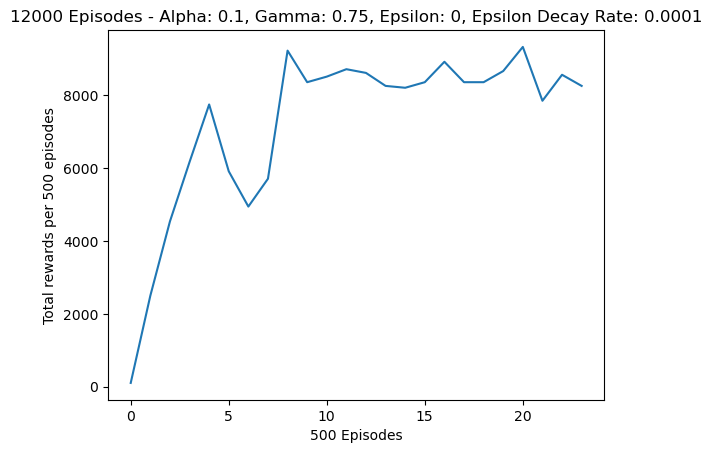

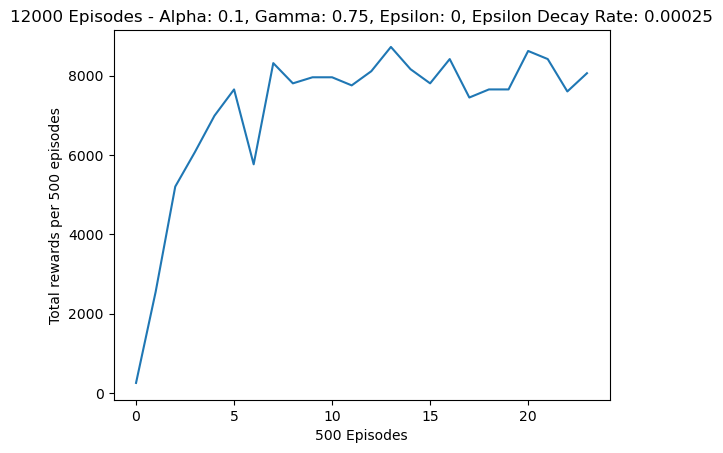

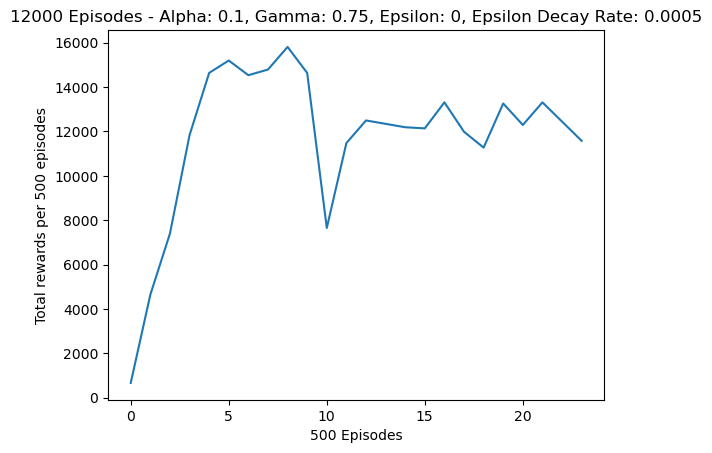

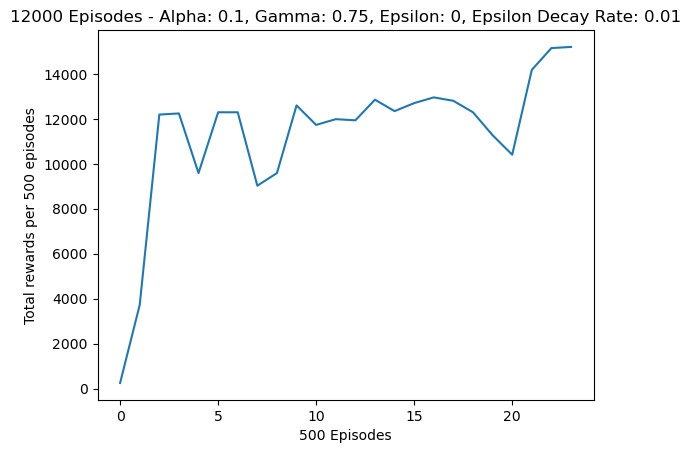

In [11]:
run(12000, alpha=0.1, gamma=0.75, epsilon=1.0, epsilon_decay_rate=0.0001, render=False, is_training=True)
run(12000, alpha=0.1, gamma=0.75, epsilon=1.0, epsilon_decay_rate=0.00025, render=False, is_training=True)
run(12000, alpha=0.1, gamma=0.75, epsilon=1.0, epsilon_decay_rate=0.0005, render=False, is_training=True)
run(12000, alpha=0.1, gamma=0.75, epsilon=1.0, epsilon_decay_rate=0.01, render=False, is_training=True)

It is surprising that the decay rate of 0.01 generates the best results. I would assume that a lower decay rate would be better since the agent would explore more. The decay rate of 0.0001 generates the worst results. The decay rate of 0.00025 generates similar results, but the decay rate of 0.01 generates the best results. The decay rate of 0.0005 peaks at a total reward of 16000 per 500 episodes but falls off at x=10 (5000 episodes).

# Conclusion

I have explored different parameters for the Frozen Lake environment with my customized punishment and reward system. 

Setting the discount factor too high means that the agent will not explore enough. Setting the discount factor too low means that the agent will not consider future rewards enough. A middle ground is optimal, and in this environment a discount factor of 0.75 seems to be viable.

The learning rate determines how much the agent learns from each step. Setting this parameter too high creates many fluctuations in the total rewards per 500 episodes. Setting this parameter too low means that the agent will not learn fast enough. A learning rate of 0.1 seems to be optimal.

The exploration rate decay determines how fast the agent will stop exploring. It seems that the agent can benefit from exploiting rather quickly in the frozen lake. A decay rate of 0.01 generates the best results.